In [8]:
#!/usr/bin/python3

import sys
import pickle
sys.path.append("../tools/")

import pandas as pd
import numpy as np
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import seaborn as sns
import matplotlib.pyplot as plt

# Task 1: Select what features you'll use.
# features_list is a list of strings, each of which is a feature name.
# The first feature must be "poi".

# By using ExtraTreesClassifier from sklearn we identified 3 features that were
# not contributing much for the model:
#                   loan_advances, director_fees, restricted_stock_deferred
# So we decided to remove these features from the analysis.
np.random.seed(1234)

features_list = ['deferred_income',
                 'expenses',
                 'exercised_stock_options',
                 'restricted_stock',
                 'from_this_person_to_poi',
                 'salary',
                 'total_stock_value',
                 'bonus',
                 'shared_receipt_with_poi',
                 'other',
                 'from_poi_to_this_person',
                 'long_term_incentive',
                 'total_payments',
                 'from_messages',
                 'to_messages',
                 'deferral_payments',
                 'poi']

# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)

# Task 2: Remove outliers
# Generate Dataframe out of the data_dict
df_enron = pd.DataFrame.from_dict(data_dict, orient='index')


# Define columns of features
# df_enron.drop('email_address', axis=1, inplace=True)
#df_enron = df_enron[features_list]

In [9]:
df_enron.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [10]:
# Change columns type to numeric
df_enron = df_enron.apply(pd.to_numeric, errors='coerce')

# Fillna with 0 to replace NaN
df_enron = df_enron.fillna(0.0)

# Rescaling feature values with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(df_enron.drop('poi', axis=1))
y = df_enron.poi

In [11]:
X

array([[7.56265983e-03, 1.91563800e-01, 9.23453242e-02, ...,
        6.28179902e-03, 0.00000000e+00, 8.90151515e-02],
       [0.00000000e+00, 0.00000000e+00, 8.74544552e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.78623393e-05, 3.73622021e-02, 3.18462472e-03, ...,
        0.00000000e+00, 0.00000000e+00, 7.38636364e-02],
       ...,
       [0.00000000e+00, 0.00000000e+00, 3.18462472e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.93175710e-03, 0.00000000e+00, 3.18462472e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.18462472e-03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [20]:
from sklearn.linear_model import LassoCV
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = df_enron.drop('poi', axis=1).columns)

Best alpha using built-in LassoCV: 0.012567
Best score using built-in LassoCV: 0.020251


In [21]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 1 variables and eliminated the other 19 variables


Text(0.5,1,'Feature importance using Lasso Model')

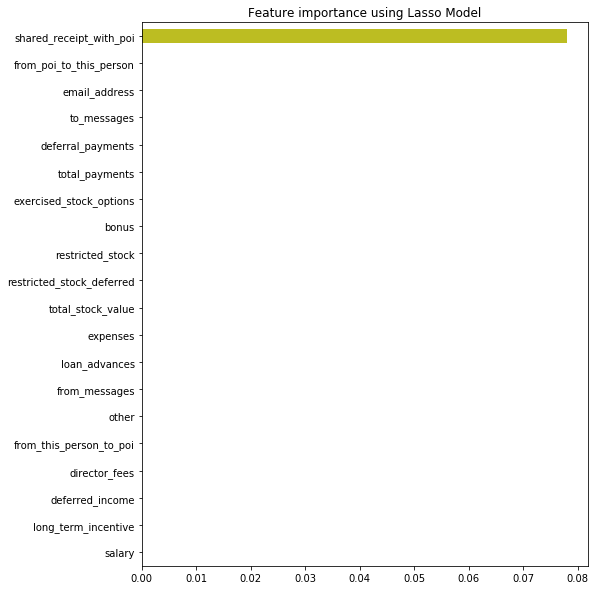

In [22]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV

# We use the base estimator LassoCV since the L1 norm promotes sparsity of features.
clf = LassoCV(cv=5)

# Set a minimum threshold of 0.25
sfm = SelectFromModel(clf, threshold=0.25)
sfm.fit(X, y)
n_features = sfm.transform(X).shape[1]

# Reset the threshold till the number of features equals two.
# Note that the attribute can be set directly instead of repeatedly
# fitting the metatransformer.
while n_features > 10:
    sfm.threshold += 0.1
    X_transform = sfm.transform(X)
    n_features = X_transform.shape[1]

In [18]:
n_features

0

NameError: name 'X_transform' is not defined

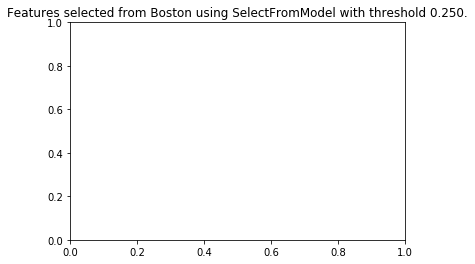

In [16]:
# Plot the selected two features from X.
plt.title(
    "Features selected from Boston using SelectFromModel with "
    "threshold %0.3f." % sfm.threshold)
feature1 = X_transform[:, 0]
feature2 = X_transform[:, 1]
plt.plot(feature1, feature2, 'r.')
plt.xlabel("Feature number 1")
plt.ylabel("Feature number 2")
plt.ylim([np.min(feature2), np.max(feature2)])
plt.show()

In [13]:
# Define X and y
# X = df_enron.drop('poi', axis=1).values
# y = df_enron['poi'].values

# Using DBSCAN to spot outliers
from sklearn.cluster import DBSCAN
outlier_detection = DBSCAN(
    eps=0.5,
    metric="euclidean",
    min_samples=3,
    n_jobs=-1)
clusters = outlier_detection.fit_predict(X)
df_dbscan = pd.DataFrame(clusters, index=df_enron.index)
#print(df_dbscan[df_dbscan[0] == -1].index)

list_dbscan_outliers = list(df_dbscan[df_dbscan[0] == -1].index)
print(list_dbscan_outliers)

# As mentioned on the report, we applied PCA to define outliers and ended
# finding one sample called "TOTAL" as a candidate outlier
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=42)
dim_red = pca.fit_transform(X)
#print(pca.singular_values_)

# Transform PCA results into Dataframe
pca_df = pd.DataFrame(dim_red, columns=[
    'PCA1', 'PCA2'], index=df_enron.index)

# Concatenate with y series as for labels
pca_df = pd.concat([pca_df, pd.DataFrame(y)], axis=1)

# Get z-score for each component
pca_df['PCA1_zscore'] = (pca_df.PCA1 - pca_df.PCA1.mean()) / pca_df.PCA1.std()
pca_df['PCA2_zscore'] = (pca_df.PCA2 - pca_df.PCA2.mean()) / pca_df.PCA2.std()


# Get rows that are 3 standard deviations away from meanlist_outliers_pca
list_outliers_pca = (pca_df[(np.abs(pca_df.PCA1_zscore) > 3)
                            | (np.abs(pca_df.PCA2_zscore) > 3)]).index

['BHATNAGAR SANJAY', 'DELAINEY DAVID W', 'KAMINSKI WINCENTY J', 'LAVORATO JOHN J', 'LAY KENNETH L', 'SHAPIRO RICHARD S', 'TOTAL']


In [47]:
pca_df.head()

,PCA1,PCA2,poi,PCA1_zscore,PCA2_zscore
ALLEN PHILLIP K,0.177156,0.087775,False,0.639173,0.319719
BADUM JAMES P,-0.154380,-0.085163,False,-0.556995,-0.310204
BANNANTINE JAMES M,-0.057899,-0.039068,False,-0.208898,-0.142305
BAXTER JOHN C,-0.177314,0.001008,False,-0.639742,0.003670
BAY FRANKLIN R,-0.158158,-0.071089,False,-0.570628,-0.258940


In [48]:
def poi_n_poi(row):
    if row.poi == False:
        return 'non-poi'
    elif row.poi == True:
        return 'poi'
    else:
        return None

pca_df['label'] = pca_df.apply(poi_n_poi, axis=1)

In [52]:
pca_df.loc[list(list_outliers_pca), 'label'] = 'outlier'

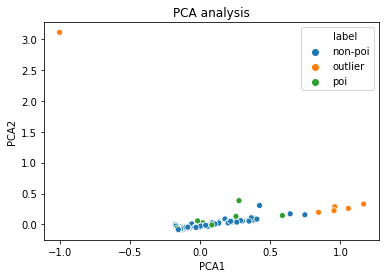

In [57]:
ax = sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='label')
ax.set_title('PCA analysis')
ax.figure.savefig('PCA_analysis_plot.png', dpi=300)

In [28]:
df_features_no_outliers = df_enron.drop(list_outliers_pca)
X = df_features_no_outliers.drop('poi', axis=1)
y = df_features_no_outliers.poi

# Spliting data into trainning and testing
from sklearn.model_selection import train_test_split
# Split your data X and y, into a training and a test set and fit the
# pipeline onto the training data
# X_train, X_test, y_train, y_test = train_test_split(None
#    X_resampled,  y_resampled, test_size=0.3,
#    random_state=0)

from imblearn.over_sampling import SMOTE
# Define the resampling method
method = SMOTE(kind='regular', random_state=42)

# Create the resampled feature set
X_resampled, y_resampled = method.fit_sample(X, y)


from sklearn.utils import shuffle
X_resampled,  y_resampled = shuffle(X_resampled,  y_resampled)


# Split your data X and y, into a training and a test set and fit the
# pipeline onto the training data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled,  y_resampled, test_size=0.5, random_state=0)


#print(df_enron)
# Task 3: Create new feature(s)
# Store to my_dataset for easy export below.
my_dataset = data_dict

# Extract features and labels from dataset for local testing
data = featureFormat(my_dataset, features_list, sort_keys=True)
labels, features = targetFeatureSplit(data)

# Task 4: Try a variety of classifiers
# Please name your classifier clf for easy export below.
# Note that if you want to do PCA or other multi-stage operations,
# you'll need to use Pipelines. For more info:
# http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                             max_depth=None, max_features='auto', max_leaf_nodes=None,
                             min_impurity_decrease=0.0, min_impurity_split=None,
                             min_samples_leaf=1, min_samples_split=2,
                             min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
                             oob_score=False, random_state=42, verbose=0,
                             warm_start=False)
print(clf)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)
probs = clf.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
print(roc_auc_score(y_test, probs[:, 1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))


# Task 5: Tune your classifier to achieve better than .3 precision and recall
# using our testing script. Check the tester.py script in the final project
# folder for details on the evaluation method, especially the test_classifier
# function. Because of the small size of the dataset, the script uses
# stratified shuffle split cross validation. For more info:
# http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html
from sklearn.model_selection import StratifiedShuffleSplit
"""
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=0)
for train_index, test_index in sss.split(X_resampled, y_resampled):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                                 max_depth=None, max_features='auto', max_leaf_nodes=None,
                                 min_impurity_decrease=0.0, min_impurity_split=None,
                                 min_samples_leaf=1, min_samples_split=2,
                                 min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
                                 oob_score=False, random_state=None, verbose=0,
                                 warm_start=False)
    clf.fit(X_train, y_train)
    predicted = clf.predict(X_test)
    probs = clf.predict_proba(X_test)

    # Print the ROC curve, classification report and confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
    print(roc_auc_score(y_test, probs[:, 1]))
    print(classification_report(y_test, predicted))
    print(confusion_matrix(y_test, predicted))
"""
# Task 6: Dump your classifier, dataset, and features_list so anyone can
# check your results. You do not need to change anything below, but make sure
# that the version of poi_id.py that you submit can be run on its own and
# generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)

['DELAINEY DAVID W', 'KAMINSKI WINCENTY J', 'LAVORATO JOHN J', 'SHAPIRO RICHARD S', 'TOTAL']
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)
0.9479166666666666
              precision    recall  f1-score   support

       False       0.92      0.91      0.91        64
        True       0.91      0.92      0.91        63

   micro avg       0.91      0.91      0.91       127
   macro avg       0.91      0.91      0.91       127
weighted avg       0.91      0.91      0.91       127

[[58  6]
 [ 5 58]]
